This notebook runs the Real (EMCCD) Image Tests in Section 4 of the manuscript. Why EMCCD images? The majority of collaborators on this project are affiliated with the MiNDSTEp consortium, and specifically, the associated microlensing follow-up observing campaign with the Lucky Imaging camera on the Danish 1.54 m (ESO, La Silla). As such, there's a strong motivation to test how well PyTorchDIA performs on these high frame rate imaging data. While the PSF is always very well sampled, it can take irregular forms, resulting in complicated convolution kernels.

In [1]:
# imports
import numpy as np
import os
import glob
from astropy.io import fits
from astropy.io.fits import getdata
from astropy.stats import mad_std
from astropy.stats import SigmaClip
from astropy.nddata import Cutout2D
from photutils import background, detection, DAOStarFinder
import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage.interpolation import shift
from scipy.stats import norm
import math
import PyTorchDIA_Newton # this is an old version of the PyTorchDIA code - used for the 'PSF' inference
import PyTorchDIA_EMCCD_NoPad
import torch
%matplotlib inline

PyTorch version: 1.6.0
PyTorch version: 1.6.0


In [2]:
# set this to True for reproducibility
#torch.backends.cudnn.deterministic = True

The following two cells setup the Cython routines required for the pyDANDIA implementation of the B08 algorithm.

In [3]:
%load_ext Cython

In [4]:
%%cython

## pyDANDIA functions consistent with no padding


from __future__ import division
import numpy as np
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
                for idx_j in range(kernel_size_half, nj_image - kernel_size_half):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
                for idx_j in range(kernel_size_half, nj_image - kernel_size_half):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
                for idx_j in range(kernel_size_half, nj_image-kernel_size_half):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
        for idx_j in range(kernel_size_half, nj_image-kernel_size_half):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
            for idx_j in range(kernel_size_half,nj_image - kernel_size_half):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(kernel_size_half, ni_image - kernel_size_half):
        for idx_j in range(kernel_size_half, nj_image - kernel_size_half):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector

In [5]:
# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

OK, let's move on to our data set. This consists of 250 EMCCD  images, each of which is formed of as many as 3000 shift-and-stacked 0.1 second exposures (i.e. approx. 5 min total integration time). Each image is 512x512 pixels, with scale of 0.09 arcsecond/pixel. First, I'll grab the reference image - this was identified as the 'best' by the associated routine in the pyDANDIA pipeline, and is also the sharpest.

In [6]:
## path to images
path = 'OGLE-III-BLG101'

In [7]:
## reference image
ref_file = os.path.join(path, 'coll_OGLE-III-BLG101_Llr_2019-07-20_00048.fits')
ref_data = getdata(ref_file, header=True)
ref, ref_fwhm, ref_totim, ref_date = ref_data[0], ref_data[1]['FWHM'], ref_data[1]['TOT_IM'],  ref_data[1]['MJD_ST']
nx, ny = ref.shape
print('Reference FWHM:', ref_fwhm)
print('Reference std:', ref_fwhm / 2.355)
print('Reference TOT_IM:', ref_totim) #  total number of shift-and-stacked exposures (max=3000)
print('Reference shape:', nx, ny) # pixels

Reference FWHM: 5.625057500773691
Reference std: 2.388559448311546
Reference TOT_IM: 3000.0
Reference shape: 512 512


In [8]:
### OPTIONAL - generate a stacked reference?
from skimage.feature import register_translation

# save np.ndarray as a .fits file    
def save_numpy_as_fits(numpy_array, filename):
    '''
    Takes a numpy aray, and saves it as a (headerless) fits file.
    '''
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)

def align(template, data):
    
    # subpixel precision shifts (via cross-correlation between template and data)
    shifts, error, diffphase = register_translation(template, data, 100)
    xs, ys = shifts[1], shifts[0]

    print('x-shift:', xs)
    print('y-shift:', ys)

    print('Resampling data to template (bicubic spline)')
    shifted_data = shift(data, (int(ys), int(xs)), order=3, cval=0)
    
    return shifted_data

##########################################

save_numpy_as_fits(ref, 'ref.fits')

ref_fwhms = []
ref_totims = []

for image_file in glob.glob(os.path.join(path, "*coll*")):
    if "2019-07-20" in image_file and "00048" not in image_file:
        print('\nFile:', image_file)
        image_data = getdata(image_file, header=True)
        image, header = image_data[0], image_data[1]
        print('FWHM:', header['FWHM'])
        print('TOT_IM:', header['TOT_IM'])
        print('Date:', header['MJD_ST'])
        print('Date diff:', header['MJD_ST'] - ref_date)
        ref_fwhms.append(header['FWHM'])
        ref_totims.append(header['TOT_IM'])
        shifted_image = align(ref, image)
        ref += shifted_image
        
#### DIVIDE STACKED REFERENCE BY THE NUMBER OF STACKED IMAGES (as in B16)??
N_ref_ims = len(ref_fwhms) + 1
print('Total number of stacked images:', N_ref_ims)
ref /= N_ref_ims
        
save_numpy_as_fits(ref, 'stacked_ref.fits')

ref_fwhm = np.max(ref_fwhms)
ref_totim = np.sum(ref_totims) + 3000 # + 3000 from template
print('Reference FWHM:', ref_fwhm)
print('Reference std:', ref_fwhm / 2.355)
print('Reference TOT_IM:', ref_totim) #  total number of shift-and-stacked exposures (max=3000)
print('Reference shape:', nx, ny) # pixels


File: OGLE-III-BLG101/coll_OGLE-III-BLG101_Llr_2019-07-20_00035.fits
FWHM: 6.864821738138722
TOT_IM: 3000.0
Date: 58684.11970511498
Date diff: -0.06732322089374065
x-shift: 8.29
y-shift: -2.05
Resampling data to template (bicubic spline)

File: OGLE-III-BLG101/coll_OGLE-III-BLG101_Llr_2019-07-20_00034.fits
FWHM: 6.631810219842555
TOT_IM: 2999.0
Date: 58684.11609726679
Date diff: -0.07093106907996116
x-shift: 5.5
y-shift: -1.89
Resampling data to template (bicubic spline)

File: OGLE-III-BLG101/coll_OGLE-III-BLG101_Llr_2019-07-20_00050.fits
FWHM: 6.704921111506455
TOT_IM: 3000.0
Date: 58684.19446237944
Date diff: 0.007434043567627668
x-shift: -0.53
y-shift: 3.7
Resampling data to template (bicubic spline)

File: OGLE-III-BLG101/coll_OGLE-III-BLG101_Llr_2019-07-20_00051.fits
FWHM: 6.498920239913948
TOT_IM: 3000.0
Date: 58684.19809795031
Date diff: 0.011069614440202713
x-shift: -2.97
y-shift: 4.25
Resampling data to template (bicubic spline)

File: OGLE-III-BLG101/coll_OGLE-III-BLG101_Ll

EMCCD image: including Excess Noise Factor in the CCD noise model
Iteration 1 of 1
Estimating 2D background on the first pass...


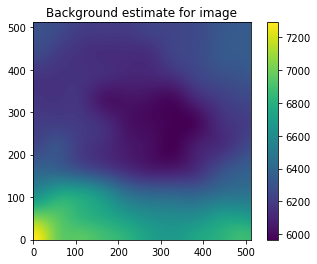

Finding initial guess for image FWHM...
FWHM_0: 12
Found a total of 372 sources!
Kept 5 source(s) for FWHM inference.


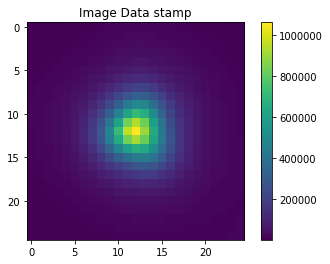

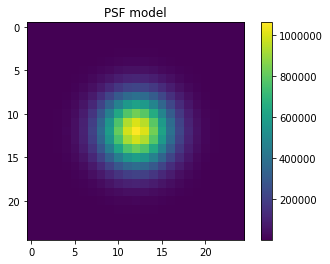

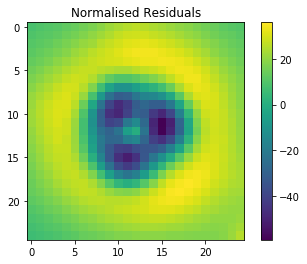

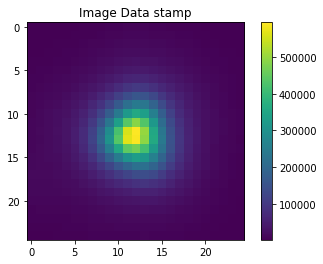

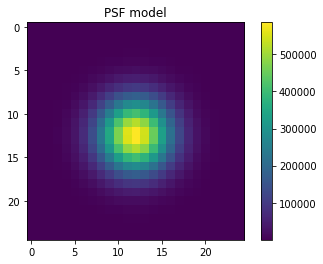

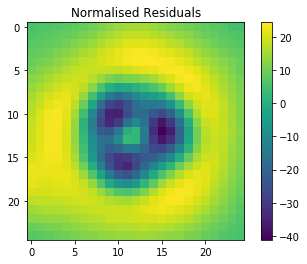

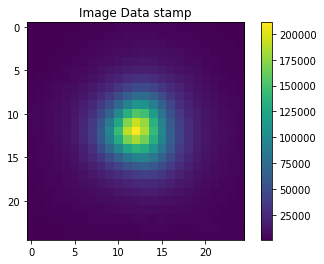

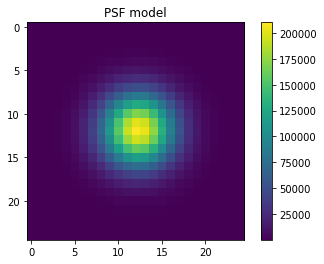

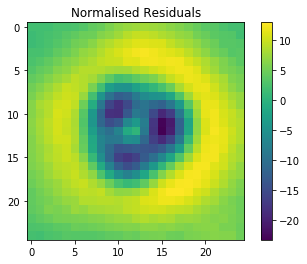

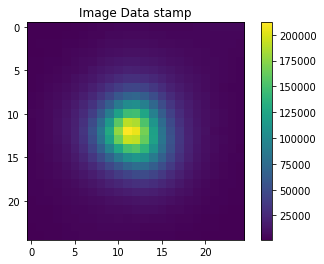

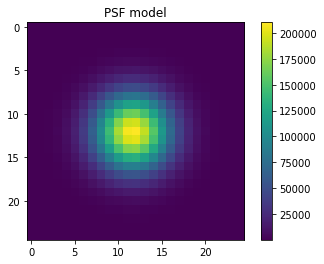

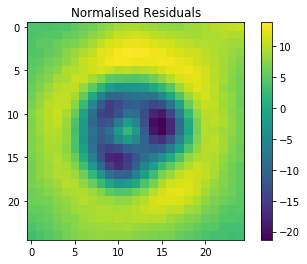

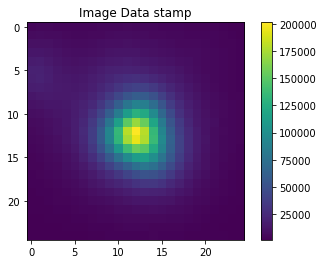

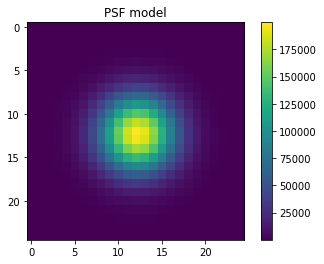

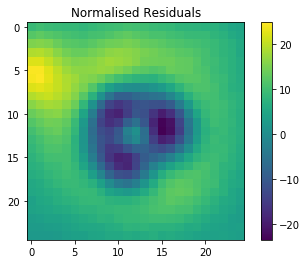

Median FWHM: 6.812011939287186
Median phi_r: 2.8925740718841553


In [9]:
## TO DO: VERFIY GAUSSIAN FWHM / PHI_R FOR STACKED REFERENCE
def source_detection(data, fwhm, thresh, saturation, psf_sources, flat, EMCCD, reference=False, rdnoise=1, G=1, N=1, diagnostics=True, empirical=False, robust=False):

    '''
    # Arguments
    * data (ndarray): Image data
    * flat (ndarray): Flat field used to calibrate 'data'
    
    # Keyword arguments
    * fwhm (float): Prior estimate of image fwhm (used for point source detection)
    * thresh (float): Detection threshold for point sources. Specifically, the number of standard deviations above the background
    * saturation (int): Saturation limit for detector
    * psf_sources (int): The maximum top number of brightest sources used to infer the FWHM
    * EMCCD (bool): If True, the usual CCD noise model will be modified to be appropriate for EMCCD images
    * reference (bool): If true, the inferred PSF model is used for optimal flux extraction of the detected sources
      to produce a source_table for the reference, which includes columns for the measured fluxes and their uncertanties
    * rdnoise (float): Detector readout noise in ADU
    * G (float): Detector gain in e-/ADU
    * N (int): If EMCCD is True, this represents the number of shift-and-stacked frames
    * diagnostics (bool): If true, plots of the measured sky background, PSF models, and (if reference == True) residuals
      following optimal flux extraction of source stamps are displayed
      
    # Returns
    * if reference == True:
        source_table (QTable): table of measured properties of detected sources in the reference frame
        psf_model (ndarray): the inferred PSF model in the reference (Bivariate 2D Moffat)
    
    * else:
        np.median(fwhm) (float): the median fwhm of 'psf_sources'
        total_sources (int): the total number of detected sources for 'data'
    '''
    
    ### if EMCCD, include Excess the Factor in the noise model
    if EMCCD == True:
        print('EMCCD image: including Excess Noise Factor in the CCD noise model')
        E = 2
    else:
        E = 1
    
    # non-negativity
    if (data <= 0).any():
        print('This image has negative pixel values, which violate the noise model!')
        dc = np.abs(np.min(data)) + 1e-3
        print('Adding a DC bias offset:', dc)
        data += dc
    
    # make a copy of the data image
    data0 = np.copy(data)
    
    # image shape
    ymax, xmax = data0.shape
    
    # if reference is True, we can apply basic differential corrections to the image model
    if reference == True:
        maxiter = 2
    else:
        maxiter = 1
        
    for iteration in range(0, maxiter):
        
        print('Iteration %d of %d' % (iteration+1, maxiter))
        
        # background subtraciton - rolling Median filter
        if iteration == 0:
            print('Estimating 2D background on the first pass...')
            sigma_clip = SigmaClip(sigma=3.)
            bkg_estimator = background.MedianBackground()
            box_shape = (50,50)
            bkg = background.Background2D(data0, box_shape, filter_size=(3, 3),
                                sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        
        if diagnostics == True:
            plt.imshow(bkg.background, origin='lower')
            plt.title('Background estimate for image')
            plt.colorbar()
            plt.show()
                    
        
        # differential correction
        if iteration > 0:
            bkg.background -= delta_S0
            plt.imshow(bkg.background, origin='lower')
            plt.title('Updated background estimate for image (scalar shift)')
            plt.colorbar()
            plt.show()
        
        # subtract the 2D background
        # N.B. 'data' here is 'sky-subtracted' (calibrated) image data
        data = data0 - bkg.background
                
        # Median Absolute Deviation
        std = mad_std(data)
        
        # find point sources
        # a priori, the fwhm is not known. Indeed, we need to first identify
        # point sources in order to infer this... as such, trial a number of 
        # fwhm fed to DAOStarFinder, and pick the one which returns the most sources
        if reference == False:
            fwhms = np.array([1, 2, 3, 4, 5, 7, 9, 12, 15])
            n_sources = np.zeros(fwhms.shape)
            print('Finding initial guess for image FWHM...')
            for f,fwhm in enumerate(fwhms):

                daofind = DAOStarFinder(fwhm=fwhm, threshold=thresh*std)
                source_table = daofind(data)
                try:
                    n_sources[f] = len(source_table)
                except TypeError:
                    n_sources[f] = 0
               
            fwhm0 = fwhms[np.where(n_sources == np.max(n_sources))][0]
            print('FWHM_0:', fwhm0)
         
        else:
            fwhm0 = fwhm
        
        daofind = DAOStarFinder(fwhm=fwhm0, threshold=thresh*std)
        source_table = daofind(data)
        
        # make a note of all detected sources in the image
        total_sources = len(source_table)
        
        print('Found a total of %d sources!' % total_sources)

        # Remove saturated stars
        sources = source_table[np.where(source_table['peak'] < saturation)]
        sources.sort('peak')
        sources.reverse()

        # Store the number of identified sources and fraction of saturated pixels
        # Discount stars too close to the edges of the image
        nstars = len(sources)
        
        # ignore sources 'x' fwhms from the image edge
        bound = np.int(3.1 * fwhm0)

        sources = sources[np.where((sources['xcentroid'] > bound) &
                          (sources['xcentroid'] < xmax-bound) &
                          (sources['ycentroid'] < ymax-bound) &
                          (sources['ycentroid'] > bound))]


        # Keep only up to 100 stars
        sources = sources[0:100]
        
        # Remove stars with close neighbours (within r=10 pix)
        sources_with_close_stars_ids = []

        for i in np.arange(len(sources)):

            source_i = sources[i]

            for other_source in sources[i+1:]:

                if (np.sqrt((source_i['xcentroid']-other_source['xcentroid'])**2 +
                         (source_i['ycentroid']-other_source['ycentroid'])**2) <= 10 ):

                    sources_with_close_stars_ids.append(i)
                        #print source_i, other_source

                continue

        # Keep up to N isolated sources only (may be fewer)
        sources.remove_rows(sources_with_close_stars_ids)
        sources = sources[0:psf_sources]

        print("Kept %s source(s) for FWHM inference." % str(len(sources)))
        
        # use fwhm as a measurement of image sharpness
        fwhms = []
        
        # store these to construct a PSF model for the reference image
        if reference is True:
            x0s = []
            y0s = []
            gamma_xs = []
            gamma_ys = []
            alphas = []
            phis = []
            

        # iterate over bright detected sources
        i = 0
        
        # stamp size for PSF fit
        ss = (np.ceil(2*fwhm0) // 2 * 2 + 1).astype(int)
        stamp_size = (ss, ss)
          
        while (i <= len(sources)-1):
        
            # stamp shape for psf_model fit
            #stamp_size = (31, 31)

            position = [sources[i]['xcentroid'], sources[i]['ycentroid']]
            cutout = Cutout2D(data, position, stamp_size) # in pixels
            bkg_cutout = Cutout2D(bkg.background, position, stamp_size)
            flat_cutout = Cutout2D(flat, position, stamp_size) 

            #yc, xc = cutout.position_cutout
            
            # create psf stamp
            psf_stamp = np.zeros(stamp_size)
            nx, ny = psf_stamp.shape
            xg, yg = np.meshgrid(range(nx), range(ny))
            centre = np.int(psf_stamp.shape[0]/2)
            
            # convert numpy arrays to tensors
            xg, yg, = torch.Tensor(xg), torch.Tensor(yg)
            stamp_data = torch.Tensor(cutout.data)
            stamp_bkg = torch.Tensor(bkg_cutout.data)
            stamp_flat = torch.Tensor(flat_cutout.data)
            
            
            if iteration == 0:
                noise_stamp = torch.sqrt(N*(rdnoise/stamp_flat)**2 + E*(stamp_data + stamp_bkg)/(G*stamp_flat))
                
            else:
                model_cutout = Cutout2D(image_model, position, stamp_size)
                stamp_model = torch.Tensor(model_cutout.data)
                noise_stamp = torch.sqrt(N*(rdnoise/stamp_flat)**2 + E*(stamp_model)/(G*stamp_flat))


            # initialise model parameters
            f = torch.nn.Parameter(torch.max(stamp_data)*torch.ones(1), requires_grad = True)
            x0 = torch.nn.Parameter(0.5*ss*torch.ones(1), requires_grad = True)
            y0 = torch.nn.Parameter(0.5*ss*torch.ones(1), requires_grad = True)
            phi_r = torch.nn.Parameter(torch.ones(1), requires_grad = True)
            
            params = list([f, x0, y0, phi_r])
            
            '''
            gamma_x = torch.nn.Parameter(torch.ones(1), requires_grad = True)
            gamma_y = torch.nn.Parameter(torch.ones(1), requires_grad = True)
            alpha = torch.nn.Parameter(torch.ones(1), requires_grad = True)
            b = torch.nn.Parameter(1e-3*torch.ones(1), requires_grad = True)
            phi = torch.nn.Parameter(1e-3*torch.ones(1), requires_grad = True) # radians
            params = list([f, x0, y0, gamma_x, gamma_y, alpha, b, phi])
            '''
            
            
            # initialise optimizer with parameter list        
            optimizer_LBFGS = torch.optim.LBFGS(params, tolerance_change=1e-9, history_size=100, line_search_fn='strong_wolfe')
            
            def closure_psf():
                optimizer_LBFGS.zero_grad()
                model = psf_model(params)
                loss = l2(stamp_data, model, noise_stamp)
                loss.backward()
                return loss
            
            def psf_model(params):
                
                '''
                # unpack parameters
                f, x0, y0, gamma_x, gamma_y, alpha, b, phi = params
                
                # create psf_model stamp
                A = (torch.cos(phi) / gamma_x)**2 + (torch.sin(phi) / gamma_y)**2
                B = (torch.sin(phi) / gamma_x)**2 + (torch.cos(phi) / gamma_y)**2
                C = 2 * torch.sin(phi) * torch.cos(phi) * ((1./gamma_x**2) - (1./gamma_y**2))
                rr_gg = A*(xg - x0)**2 + B*(yg - y0)**2 + C*(xg - x0)*(yg - y0)
                psf_stamp = f * ((1 + rr_gg) ** (-alpha)) + b 
                '''
                
                f, x0, y0, phi_r = params
                
                rr_gg = (- 0.5 * phi_r**(-2)) * ((xg - x0)**2 + (yg - y0)**2)
                psf_stamp = f * torch.exp(rr_gg)
                
                return psf_stamp           

            # define some scalar objective function to minimise
            def l2(data, model, uncertanties):
                # l2 norm
                l2 = (data - model)**2 / uncertanties**2
                return torch.sum(l2)

            # keep track of losses
            losses = []
            
            for epoch in range(50): 
              
                optimizer_LBFGS.step(closure_psf)
                
                model = psf_model(params)
                
                loss = l2(stamp_data, model, noise_stamp)

                losses.append(loss.item())
                
                if epoch > 1 and abs((losses[-1] - losses[-2])/ losses[-2]) < 1e-9:
                    break


            if diagnostics == True:
                plt.imshow(stamp_data.detach().numpy())
                plt.title('Image Data stamp')
                plt.colorbar();
                plt.show();

                plt.imshow(model.detach().numpy())
                plt.title('PSF model')
                plt.colorbar()
                plt.show();
                
                plt.imshow((stamp_data.detach().numpy() - model.detach().numpy()) / noise_stamp.detach().numpy())
                plt.title('Normalised Residuals')
                plt.colorbar()
                plt.show();
            
            
            # psf shape parameters
            #f, x0, y0, gamma_x, gamma_y, alpha, b, phi = f.item(), x0.item(), y0.item(), gamma_x.item(), gamma_y.item(), alpha.item(), b.item(), phi.item()
            #print('(Normalised) PSF fit parameters (Moffat 2D):')
            #print('f, x0, y0, gamma_x, gamma_y, alpha, b, phi:', f, x0, y0, gamma_x, gamma_y, alpha, b, phi)
            
            f, x0, y0, phi_r = f.item(), x0.item(), y0.item(), phi_r.item()
            
            # compute fwhm
            #gamma = np.sqrt(gamma_x**2 + gamma_y**2)
            #gamma = (gamma_x + gamma_y) / 2.0
            #fwhm = 2.0 * np.abs(gamma) * np.sqrt(2.0 ** (1.0 / alpha) - 1.0)
            fwhm = 2.355 * phi_r
            
            fwhms.append(fwhm)
                        
            if reference is True:
                x0s.append(x0)
                y0s.append(y0)
                gamma_xs.append(gamma_x)
                gamma_ys.append(gamma_y)
                alphas.append(alpha)
                phis.append(phi)
                

            i = i + 1
            
    return fwhms
            
fwhms = source_detection(ref, ref_fwhm, thresh=5, saturation=1e10, psf_sources=5, flat=np.ones(ref.shape),
                 EMCCD=True,
                 reference=False,
                 rdnoise=2.55, G=25.8/300, N=3000, diagnostics=True, empirical=False, robust=False)

print('Median FWHM:', np.median(fwhms))
print('Median phi_r:', np.median(fwhms) / 2.355)
ref_fwhm = np.median(fwhms)

For these tests we will need to perform PSF-fitting photometry to assess the photometric accuracy of the B08 and PyTorchDIA approaches. We therefore need an accurate model PSF in these images. Due to the complicated nature of the Lucky Imager's PSF, analytical models such as Gaussians and Moffat's won't cut it; we need to construct an empirical model!

It turns out that we can use some flavour of PyTorchDIA to do just this. If we were to replace our reference image with (approximate) delta-functions only at the positions of the stars and set all other pixels to 0, the associated 'kernel' that convolves this representation of the scene to any given data image should be a reasonable model for the PSF of that data image. Let's start by constructing this 'delta-function' scene.

In [10]:
## find bright star peaks above given threshold (sky subtract)
## we'll also use this source list in the next cell to identify
## suitable stars for the PSF fitting photometry.
sky, std, thrs = np.median(ref), mad_std(ref), 5
daofind_bright = DAOStarFinder(fwhm=ref_fwhm, threshold=thrs*std)  
sources = daofind_bright(ref - sky)

ref_delta_positions = np.transpose((sources['xcentroid'], sources['ycentroid'], sources['peak']))

# delta function positions
dbf_x = ref_delta_positions[:,0].astype(int)
dbf_y = ref_delta_positions[:,1].astype(int)

# mask non peak positions
mask_image = np.zeros(ref.shape)
mask_image[dbf_y, dbf_x] = 1

# apply mask to a copy of the reference image
ref_delta = np.copy(ref)
ref_delta[mask_image == 0] = 0

In [11]:
print('Detected a total of %d sources' % len(sources))

# avoid bad regions at the edges
#source_table = sources[(sources['xcentroid'] > 50) & (sources['xcentroid'] < (nx - 50))]
#source_table = source_table[(source_table['ycentroid'] > 50) & (source_table['ycentroid'] < (ny - 60))]

source_table = sources[(sources['xcentroid'] > 71) & (sources['xcentroid'] < (nx - 71))]
source_table = source_table[(source_table['ycentroid'] > 71) & (source_table['ycentroid'] < (ny - 71))]

# brightness cut
#plt.hist(source_table['peak'], bins=400)
#plt.xlim(-1, 2e5)
#plt.show();
#print(len(source_table[source_table['peak'] > 1e4]))
source_table = source_table[source_table['peak'] > 3e4]

print('Whittled down to %d sources after flux cut' % len(source_table))

# identified variables and/or sources missing entries
ignore = np.array([ 0,  1, 22, 25, 27, 28, 33])
ignore_ids = source_table[ignore]['id']

for ii in ignore_ids:
    source_table = source_table[source_table['id'] != ii]
    
    
print('Using %d sources to assess photometric accuracy.' % len(source_table))

Detected a total of 236 sources
Whittled down to 37 sources after flux cut
Using 30 sources to assess photometric accuracy.


In [12]:
## master flat
#path = 'LOB190560Z'

#flat_file = os.path.join(path, 'master_flat.fits')
#master_flat = getdata(flat_file, 0, header=True)[0]

## shifts
shift_info = os.path.join(path, 'Shift_info.txt')
shifts = np.genfromtxt(shift_info, delimiter="\t", dtype=str) # filename | xs | ys

# store some of the house-keeping data
fnames = []
images = []
FWHMs = []
Tot_ims = []

# avoid reference and a file with a badly incorrect pointing
avoid = [ref_file, '2019-07-28_00000.fits']

print('Avoiding all images acquired on 2019-07-20, as these were used to construct the reference frame.')
for image_file in glob.glob(os.path.join(path, "*coll*")):
    if image_file not in avoid and '2019-07-20' not in image_file:
        image_data = getdata(image_file, header=True)
        image, header = image_data[0], image_data[1]
        # there are some 30 Hz exposures mixed in with the 10 Hz we're interested in,
        # so avoid any image where TOT_IM > 3000
        if header['TOT_IM'] <= 3000.0:
            fnames.append(image_file.split('/')[-1])
            images.append(image)
            FWHMs.append(header['FWHM'])
            Tot_ims.append(header['TOT_IM'])
        

# we'll also need the master flat fields to include in our noise model
master_flats = []
master_flat_dates = []
for flat_file in glob.glob(os.path.join(path, "Master_flats_OGLE-III-BLG101/*.fits")):
    flat = getdata(flat_file, header=False)
    master_flats.append(flat)
    master_flat_dates.append(flat_file.split('_')[-1].split('.')[0])


# convert to numpy arrays (float32)
#images, FWHMs, Tot_ims = np.array(images, dtype=np.float32), np.array(FWHMs), np.array(Tot_ims, dtype=np.int)
#master_flats = np.array(master_flats, dtype=np.float32)
print('Found a total of %d useful data images.' % len(images))

Avoiding all images acquired on 2019-07-20, as these were used to construct the reference frame.
Found a total of 238 useful data images.


In [15]:
## For comparison with the simulated image tests in Section 3, which kernel sampling regime are we in?
## oversampled kernel
fwhm_k = np.sqrt(np.array(FWHMs)**2 - ref_fwhm**2)
## convert fwhm to standard deviation N.B. this is a very course estimate of phi_k
## since the PSF of the Danish is not well approximated by a Gaussian in general
phi_k = fwhm_k / 2.355
print(phi_k.shape)
print(phi_k)
## oversampled kernel
print('Instances with oversampled kernel:', len(phi_k[phi_k > 1]))
print('Instances with undersampled kernel:', len(phi_k[phi_k < 1]))
print('Median and max phi_i:', np.median(np.array(FWHMs)) / 2.355, np.max(np.array(FWHMs)) / 2.355)

(238,)
[3.14219199 2.41733805 1.09689339 4.22523653 3.5117746  3.45823451
 3.5723281  2.63089154 3.18276821 2.80895059 1.415985   1.11882166
 2.82611483 3.5660924  3.40354224        nan 1.8555535  3.52065596
 3.70161289        nan 1.8549917  0.4234861         nan 0.76949545
 1.24676481 4.29423284 5.09378236 2.77202226 0.95561587 2.27167058
        nan 2.20548439 3.5531202  4.24281195 4.5698718  3.57298275
 6.00587507 1.56524439 2.75346048 3.57068242 4.09116338 2.84097105
        nan 2.40304959 4.12467285 2.62677103 3.23337197 2.15015375
 2.60976464        nan 0.367141   3.12480657 1.83862736 3.4316581
        nan 2.99664091 1.28653674 1.47696326 2.28502855 2.49308528
 1.66220986 3.52955404        nan 3.88074118 2.7945867  2.46677978
 3.81002682 2.05881257 5.18079643 3.29280986 2.6959888  2.16098078
 4.59501431 3.10246191 4.13595938 2.0238274  2.16908004 3.45453217
        nan        nan 2.30482984 3.13465945 3.31883201 1.73124555
 3.59217395        nan 0.73096224 1.84641087 2.86102711 

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


In [36]:
## max fwhm
len(FWHMs), np.median(FWHMs) / 2.355, np.max(FWHMs) / 2.355
3 * np.min(FWHMs), 3 * np.median(FWHMs), 3 * np.max(FWHMs)
3 * 2.355

7.0649999999999995

In [15]:
## identify images with undersampled kernels (may have some issue with the PSF fitting here)
subsample = np.array(FWHMs)[phi_k < 1]
print(subsample.shape)
#print(np.array(fnames)[np.where(np.array(FWHMs) <= np.max(subsample))[0]])
#print(np.mean(phi_k[phi_k < 1]))
#[np.where(np.array(FWHMs) <= np.max(subsample))[0]]

(16,)


/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Let's define some house-keeping functions for padding the images (in order to guard against edge-effects associated with convolution), computing fit quality metrics and for cutting out stamps for the PSF fitting photometry.

In [16]:
# extend image prior to convoliving with kernel
def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended


def extend_image_hw(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + kernel_size - 1,
                             np.shape(image)[1] + kernel_size - 1))
    hwidth = np.int((kernel_size - 1) / 2)
    image_extended[hwidth:image_extended.shape[0]-hwidth,
                   hwidth:image_extended.shape[1]-hwidth] = np.array(image, float)
    return image_extended

# define function to return fit quality metrics
def metrics(M, I, noise_map, kernel_size, mask):
    N_data = len(I[mask == 0].flatten())
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# cutout stamp around position of selected stars
def make_stamp(image, pos, stamp_size):
    rad = np.int(stamp_size/2)
    #x_centroid, y_centroid = pos[1], pos[0]
    x_centroid, y_centroid = pos[1].astype(int), pos[0].astype(int)
    x_max, x_min = x_centroid + rad, x_centroid - rad
    y_max, y_min = y_centroid + rad, y_centroid - rad
    stamp = image[x_min:x_max+1, y_min:y_max+1]
    return stamp

# cutout stamp around position of selected stars
def make_fit_cutout(image_stamp, c_size):
    centre = np.int(image_stamp.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image_stamp[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    return cutout



def evaluate_gaussian_log_likelihood(data, model, var):
    #print('\nGaussian log-likelihood')
    chi2 = 0.5 * ((data - model)**2 / var).sum()
    lnsigma = np.log(np.sqrt(var)).sum()
    norm_constant = len(data.flatten()) * 0.5 * np.log(2 * np.pi)
    #print('chi2, lnsigma, norm_constant:', chi2, lnsigma, norm_constant)
    return -(chi2 + lnsigma + norm_constant)

def evaluate_huber_log_likelihood(data, model, var, c=1.345):
    #print('\nHuber log-likelihood')
    
    ## PyTorchDIA - 'Huber' likelihood
    sigma = np.sqrt(var)
    ln_sigma = np.log(sigma).sum()

    # gaussian when (model - targ)/sigma <= c
    # absolute deviation when (model - targ)/sigma > c
    cond1 = np.abs((model - data)/sigma) <= c
    cond2 = np.abs((model - data)/sigma) > c
    inliers = ((model - data)/sigma)[cond1]
    outliers = ((model - data)/sigma)[cond2]

    l2 = 0.5*(np.power(inliers, 2)).sum()
    l1 = (c *(np.abs(outliers)) - (0.5 * c**2)).sum()

    constant = (np.sqrt(2 * np.pi) * math.erf(c / np.sqrt(2))) + ((2 / c) * np.exp(-0.5 * c**2)) 
    norm_constant = len(data.flatten()) * np.log(constant)
    ll = -(l2 + l1 + ln_sigma + norm_constant)
    #print('l2, l1, ln_sigma, norm_constant:', l2, l1, ln_sigma, norm_constant)
    return ll



def P_true_calc(y_positions, photometric_scale_factors_pd, s):
    
    y_pos = y_positions[s]
    ys = np.array(y_positions)
    ps = np.array(photometric_scale_factors_pd)
    
    if 50 < y_pos < 150:
        P_true = np.nanmedian(ps[(ys > 50) & (ys < 150)])
    elif 150 < y_pos < 250:
        P_true = np.nanmedian(ps[(ys > 150) & (ys < 250)])
    elif 250 < y_pos < 350:
        P_true = np.nanmedian(ps[(ys > 250) & (ys < 350)])            
    elif 350 < y_pos < 450:
        P_true = np.nanmedian(ps[(ys > 350) & (ys < 450)])

        
    return P_true

Now we're ready to perform difference imaging on this data set! We do not resample the data images to the reference image, and so avoid introducing correlated pixel noise into our data. Instead, we cutout 100x100 pixel subregions centered on the stars identified above, to within the nearest integer pixel shift. One crucial advantage of the discrete pixel array kernel that both the B08 and PyTorchDIA models use, is that subpixel shifts between images can be corrected for in the kernel solution. Consequently, if we convolve a PSF centered at the position of some star in the reference image with the inferred kernel, the result is a PSF for the data image at the position of the star in this data image. No resampling to perfectly register the star positions is required - the kernel takes care of that for us!

In [17]:
## 'sky' subtract reference - over this 45x45 arcsecond FOV, a simple scalar subtraction is fine
## even for this fairly crowded field. There is a gradient in the backgrond at the LI camera edges,
## but we've avoided those regions as part of the star selection criteria above.
sky = np.median(ref)
ref -= sky
print('Sky level of reference [ADU]:', sky)

Sky level of reference [ADU]: 6598.015


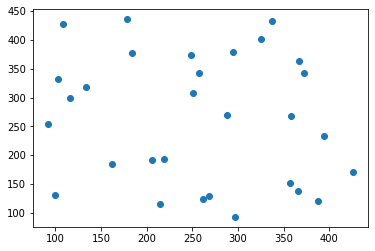

In [18]:
# grab positions of the 'good' stars
positions = np.transpose((source_table['xcentroid'], source_table['ycentroid']))
plt.scatter(positions[:,0], positions[:,1]);

In [23]:
## iterate through target images
start_time = time.time()

# size of cutouts to make i.e. 100 x 100 pixels
cutout_size = 142

# EMCCD detector parameters to plug into the noise model
# for these long, ~5 minute exposures, shot noise >> readout noise
# on this camera, so we can ignore the latter
gain_CCD = 25.8 # CCD gain [e-_EM / ADU]
gain_EM = 300. # EM gain [e-_EM / e-_phot]
G = gain_CCD / gain_EM # Total gain [e-_phot / ADU]
excess_noise_factor = 2 # EMCCD fudge factor

for i, image in enumerate(images):
    
    t0 = time.time()
    
    ##### pick up from where we last left off ####
    #if FWHMs[i] in subsample: # i < 1e99 if
    #if i < 1e99:
    if i > 168:
    
        #out_pd = np.vstack((MFBs_pd, MFVs_pd, Ps_normalised_pd, np.array(norm_phot_resids_pd).flatten(),
        #                 image_SNRs_pd, image_FWHMs_pd, stamp_ids_pd)).T

        image_FWHMs_pd = []
        image_SNRs_pd = []
        MFBs_pd = []
        MFVs_pd = []
        Ps_normalised_pd = []
        B0s_pd = []
        norm_phot_resids_pd = []
        stamp_ids_pd = []
        ll_pds = []
        image_id_pds = []

        image_FWHMs_pt = []
        image_SNRs_pt = []    
        MFBs_pt = []
        MFVs_pt = []
        Ps_normalised_pt = []
        B0s_pt = []
        norm_phot_resids_pt = []
        stamp_ids_pt = []
        ll_pts = []
        image_id_pts = []

        print('Image %d / %d' % (i, len(images)))
        print(fnames[i])

        # load corresponding flat
        date = fnames[i].split('_')[3]
        flat_index = np.where(np.array(master_flat_dates) == date)[0][0]
        print('Using flat:', master_flat_dates[flat_index])
        master_flat = master_flats[flat_index]

        # compute appropriate stamp and kernel size
        # the former will be used for PSF fitting photometry
        # a square (2 * FWHM) x (2 * FWHM) stamp is a reasonable choice
        fwhm = FWHMs[i]
        print('Image FWHM:', fwhm)
        #ks = np.int(2*fwhm)
        ks = np.int(3*fwhm)
        if ks % 2 == 0: # must be odd!
            ks += 1
        print('Stamp and kernel size:', ks)
        
        # this is used for padding the image borders
        hwidth = np.int((ks - 1) / 2)

        # find integer shifts
        ys = shifts[:,1][np.where(shifts[:,0] == fnames[i])][0] 
        xs = shifts[:,2][np.where(shifts[:,0] == fnames[i])][0]

        # x and y need to be switched
        shiftxy = np.array([xs.astype(int), ys.astype(int)])

        # store values for photometric accuracy metrics
        # requires relative P for P_true
        photometric_scale_factors_pd = []
        F_measured_values_pd = []
        photometric_scale_factors_pt = []
        F_measured_values_pt = []    
        target_psf_objects = []
        pixel_uncertainties_list = []
        
        ## position-dependent correction to photometric scale factor
        y_positions = []


        ## for each image, divide this into image and reference stamps centered on a star ##
        ## solve a kernel and background term for each, and perform psf fitting at the    ##
        ## position of the star in the difference image.

        ## deal with nans on first pass ##
        for j,pos in enumerate(positions[:, [0,1]]):

            try:

                # add shifts to positions so we get the right part of the reference and flat
                print('Source position in reference frame:', pos)
                print('Integer shift (x, y):', shiftxy)
                ref_stamp = make_stamp(ref, pos, cutout_size)
                image_stamp = make_stamp(image, pos + shiftxy, cutout_size)
                flat_stamp = make_stamp(master_flat, pos + shiftxy, cutout_size)
                ref_delta_stamp = make_stamp(ref_delta, pos, cutout_size)
                
                ################################################################################
                ######################## pyDANDIA ##############################################
                ## run pyDANDIA to build the bad pixel mask and pixel uncertainties so we compare
                ## like with like when calculating metrics
                mask = np.zeros(image_stamp.shape) # bad pixel mask
                iterations = 3
                for iters in range(0, iterations):

                    if iters == 0:
                        shot_noise = image_stamp/(G*flat_stamp)
                    else:
                        shot_noise = model_pd/(G*flat_stamp)   

                    pixel_variances = excess_noise_factor*shot_noise
                    weights_stamp = 1./pixel_variances
                    
                    # mask 5-sigma outliers
                    if iters > 1:
                        # update mask on third and fourth iterations only
                        norm_resids = np.sqrt(weights_stamp)*(image_stamp - model_pd)
                        mask[np.where(np.abs(norm_resids)>5)] = 1
                        
                    # weight-out bad pixels
                    weights_stamp[np.where(mask == 1)] = 1e-99
                    print('\nMasked pixels (pyDANDIA):', np.sum(mask))
                    
                    print('\npyDANDIA solution, iter %d' % iters)
                    
                    # pad input images by half the kernel size
                    #ext_ref = extend_image_hw(ref_stamp, ks)
                    #ext_imag = extend_image_hw(image_stamp, ks)
                    #ext_weights = extend_image_hw(weights_stamp, ks)
                    
                    U, b = construct_kernel_and_matrices(ks, ref_stamp, image_stamp, weights_stamp)
                    kernel_pd, B0_pd = lstsq_solution(ref_stamp, image_stamp, U, b, ks)
                    print('P:', np.sum(kernel_pd))
                    print('B0:', B0_pd)

                    # compute the model - B08/pyDANDIA
                    '''
                    ext_ref_stamp = extend_image_hw(ref_stamp, ks)
                    ext_model_pd = convolve2d(ext_ref_stamp, kernel_pd, mode='same') + B0_pd
                    model_pd = ext_model_pd[hwidth:ext_model_pd.shape[0]-hwidth,
                                            hwidth:ext_model_pd.shape[1]-hwidth]   
                    '''
                    
                    model_pd = convolve2d(ref_stamp, kernel_pd, mode='same') + B0_pd


                    if iters == iterations - 1:
                        # calculate pixel uncertainties on the final, fourth iteration
                        shot_noise = model_pd/(G*flat_stamp)
                        pixel_variances = excess_noise_factor*shot_noise
                        pixel_uncertainties = np.sqrt(pixel_variances)
                        
                        '''
                        plt.figure(figsize=(10,10))
                        plt.imshow(norm_resids, origin='lower')
                        plt.colorbar()
                        plt.show();
                        
                        
                        plt.figure(figsize=(10,10))
                        plt.imshow(mask, origin='lower')
                        plt.colorbar()
                        plt.show();
                        
                        plt.figure(figsize=(10,10))
                        plt.imshow(model_pd - model_pd2, origin='lower')
                        plt.colorbar()
                        plt.show();
                        '''

                #########################################################################
                #########################################################################
                
                ##################### PyTorchDIA ########################################
                # infer kernel via robust PyTorchDIA code
                print('\n(Robust) PyTorchDIA solution')
                SD_steps = 10000
                kernel_pt, B0_pt = PyTorchDIA_EMCCD_NoPad.DIA(ref_stamp,
                                                           image_stamp,
                                                           flat_stamp,
                                                           read_noise = 0.,
                                                           ks = ks,
                                                           lr_kernel = 3e-4,
                                                           lr_B = 1e2,
                                                           SD_steps = SD_steps,
                                                           Newton_tol = 1e-6,
                                                           poly_degree=0,
                                                           fast=True,
                                                           tol = 1e-9,
                                                           max_iterations = SD_steps,
                                                           fisher=False,
                                                           show_convergence_plots=False)
                
                
                # compute the model - PyTorch
                #ext_ref_stamp = extend_image_hw(ref_stamp, ks)
                #ext_model_pt = convolve2d(ext_ref_stamp, kernel_pt, mode='same') + B0_pt
                #model_pt = ext_model_pt[hwidth:ext_model_pt.shape[0]-hwidth,
                #                        hwidth:ext_model_pt.shape[1]-hwidth] 
                
                model_pt = convolve2d(ref_stamp, kernel_pt, mode='same') + B0_pt

                
                # and variances for evaluating the Huber 'likelihood'
                shot_noise_pt = model_pt/(G*flat_stamp)
                pixel_variances_pt = excess_noise_factor*shot_noise_pt
                ############################################################################
                ############################################################################

                #### PSF fitting photometry in difference image ####
                #### infer PSF - this is unweighted ###
                
                res = PyTorchDIA_Newton.DIA(ref_delta_stamp, image_stamp, flat_stamp,
                                              tot_im = Tot_ims[i], unweighted=True,
                                              iters=1, ks = ks, SD_steps = 0,
                                              tol = 1e-9, k=1e99)
                
                
                
                '''
                image_stamp_mini = make_stamp(image, pos + shiftxy, ks)
                flat_stamp_mini = make_stamp(master_flat, pos + shiftxy, ks)
                ref_delta_stamp_mini = make_stamp(ref_delta, pos, ks)
                
                res = PyTorchDIA_Newton.DIA(ref_delta_stamp_mini, image_stamp_mini, flat_stamp_mini,
                                              tot_im = Tot_ims[i], unweighted=True,
                                              iters=1, ks = ks, SD_steps = 0,
                                              tol = 1e-9, k=1e99)                
                
                '''
                psf = res[0]
                psf /= np.sum(psf)
                
                save_numpy_as_fits(psf, 'psf.fits')
                
                ############################################################################
                
                #### trim images down images to the region associated with only valid convolutions ####
                
                ### trim Model and data image ##
                hwidth = np.int((ks - 1) / 2)
                nx, ny = image_stamp.shape
                image_stamp = image_stamp[hwidth:nx-hwidth, hwidth:nx-hwidth] 
                flat_stamp = flat_stamp[hwidth:nx-hwidth, hwidth:nx-hwidth] 
                mask = mask[hwidth:nx-hwidth, hwidth:nx-hwidth]
                pixel_uncertainties = pixel_uncertainties[hwidth:nx-hwidth, hwidth:nx-hwidth] 
                pixel_variances = pixel_variances[hwidth:nx-hwidth, hwidth:nx-hwidth] 
                pixel_variances_pt = pixel_variances_pt[hwidth:nx-hwidth, hwidth:nx-hwidth] 
                model_pd = model_pd[hwidth:nx-hwidth, hwidth:nx-hwidth] 
                model_pt = model_pt[hwidth:nx-hwidth, hwidth:nx-hwidth] 
                
                
                ## Difference Image
                
                D = image_stamp - model_pd
                Dnr = D / np.sqrt(pixel_variances)
                '''
                plt.figure(figsize=(5,5))
                plt.hist(Dnr.flatten(), bins='auto', density=True)
                x = np.linspace(-5, 5, 100)
                plt.plot(x, norm.pdf(x, 0, 1))
                plt.xlim(-5, 5)
                plt.xticks(fontsize=20)
                plt.yticks(fontsize=20)
                plt.xlabel('Normalised residuals', fontsize=20)
                plt.ylabel('Probability', fontsize=20)
                plt.show();
                '''
                save_numpy_as_fits(Dnr, 'Dnr.fits')
                            
            
                
                ### compute likelihood ratio only if there is no data rejection in
                ### the 'valid convolution' region
                if np.sum(mask) == 0:
                    ll_pd = evaluate_gaussian_log_likelihood(image_stamp, model_pd, pixel_variances)
                    ll_pt = evaluate_huber_log_likelihood(image_stamp, model_pt, pixel_variances_pt, c=1.345)                
                    print('pyDANDIA (Gaussian) log-likelihood:', ll_pd)
                    print('PyTorch (Huber) log-likelihood:', ll_pt)
                    print('ll_pd - ll_pt:', ll_pd - ll_pt)
                    
                    ll_pds.append(ll_pd)
                    ll_pts.append(ll_pt)
                    
                else:
                    ll_pds.append(0)
                    ll_pts.append(0)                    

                # image models
                models = [model_pd, model_pt]

                for model in models:

                    if model is model_pd:
                        print('\nCalculating pyDANDIA metrics')
                    else:
                        print('\nCalculating PyTorchDIA metrics')

                    stamp_fit = make_fit_cutout(image_stamp - model, ks)
                    noise_stamp_fit = make_fit_cutout(pixel_uncertainties, ks)

                    '''
                    def linear_regression(x, y, yerr):
                        A = np.vander(x, 2)
                        p = np.linalg.solve(np.dot(A.T, A / yerr[:, None]**2), np.dot(A.T, y / yerr**2))
                        cov = np.linalg.inv(np.dot(A.T, A / yerr[:, None]**2)) # covariance matrix
                        var = np.diag(cov) # variances
                        # output ML parameters, (square-rooted) variances and covariance
                        m, b, sigma_m, sigma_b, sigma_mb = p[0], p[1], np.sqrt(var[0]), np.sqrt(var[1]), cov[0][1]
                        return p[0], p[1], sigma_m, sigma_b, sigma_mb
                    
                    # collapse stamps into 1D
                    target_psf_object = psf
                    x, y, yerr = target_psf_object.flatten(), stamp_fit.flatten(), noise_stamp_fit.flatten()

                    ## MLE for fit parameters using all the data ##
                    res = linear_regression(x, y, yerr)
                    F_diff, const, var_F, var_const = res[0:4]
                    
                    #prediction = F_diff*x + const
                    #plt.errorbar(x, y, yerr, marker='o', linestyle='None')
                    #plt.plot(x, prediction)
                    #plt.show();
                    
                    print('Final F and const:', F_diff, const)
                    '''
     
                    ## psf fit
                    F_diff = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                    const = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                    print('Starting F_diff and const:', F_diff, const)

                    #print(model.shape, stamp_fit.shape, noise_stamp_fit.shape)
                                        

                    target_psf_object = torch.from_numpy(psf)
                    stamp_fit = torch.from_numpy(np.array(stamp_fit, dtype=np.float32))
                    noise_stamp_fit = torch.from_numpy(np.array(noise_stamp_fit, dtype=np.float32))

                    class log_likelihood(torch.nn.Module):

                        def forward(model, stamp, noise_stamp):
                            #print(stamp.size(), model.size(), noise_stamp.size())
                            #loglikelihood = -0.5*(((stamp - model)/noise_stamp)**2).sum()

                            ln_sigma = torch.sum(torch.log(noise_stamp))

                            # gaussian when (model - targ)/NM <= c
                            # absolute deviation when (model - targ)/NM > c
                            c = 1.345
                            cond1 = torch.abs((model - stamp)/noise_stamp) <= c
                            cond2 = torch.abs((model - stamp)/noise_stamp) > c
                            inliers = ((model - stamp)/noise_stamp)[cond1]
                            outliers = ((model - stamp)/noise_stamp)[cond2]

                            l2 = 0.5*torch.sum(torch.pow(inliers, 2))
                            l1 = (c * torch.sum(torch.abs(outliers)) - (0.5 * c**2))

                            nll = l2 + l1 + ln_sigma
                            #return -loglikelihood
                            return nll

                    optimizer = torch.optim.Adam([F_diff, const], lr=1000)

                    tol = 1e-10
                    losses = []
                    for step in range(0, 150000):
                        optimizer.zero_grad()
                        psf_model = F_diff*target_psf_object + const
                        loss = log_likelihood.forward(psf_model, stamp_fit, noise_stamp_fit)
                        losses.append(loss.item())
                        loss.backward()
                        optimizer.step()

                        if step>1 and abs((losses[-1] - losses[-2])/losses[-2]) < tol:
                            print('Converged')
                            break

                    
                    print('Final F and const:', F_diff, const)

                    ## convert tensors back to numpy arrays
                    F_diff = F_diff.detach().numpy()
                    const = const.detach().numpy()
                    target_psf_object = target_psf_object.detach().numpy()
                    stamp_fit = stamp_fit.detach().numpy()
                    noise_stamp_fit = noise_stamp_fit.detach().numpy()
                    
                    save_numpy_as_fits(make_fit_cutout(image_stamp, ks), 'data_image_stamp.fits')
                    
                    '''
                    # plot the image stamp - to check psf accurate!
                    plt.figure()
                    plt.title('Data Image stamp')
                    plt.imshow(make_fit_cutout(image_stamp, ks))
                    plt.colorbar()
                    plt.show();

                    # plot the psf model
                    plt.figure()
                    plt.title('Normalised PSF model')
                    plt.imshow(target_psf_object)
                    plt.colorbar()
                    plt.show();
                                        
                    # plot the stamp
                    plt.figure()
                    plt.title('Difference image stamp')
                    plt.imshow(stamp_fit)
                    plt.colorbar()
                    plt.show();
                    
                    # plot the residuals
                    #prediction = F_diff*target_psf_object + const
                    #residuals = prediction - stamp_fit
                    plt.figure()
                    plt.title('Normalised Residuals from PSF fit to difference image stamp')
                    plt.imshow(residuals / noise_stamp_fit)
                    plt.colorbar()
                    plt.show();
                    '''
                    
                    prediction = F_diff*target_psf_object + const
                    residuals = prediction - stamp_fit
                    print('Variance of fit residuals:', np.var(residuals / noise_stamp_fit))
                    

                    if model is model_pd:

                        ## Measured flux of brightest star
                        F_measured_pd = F_diff / np.sum(kernel_pd)

                        # store values to cal
                        F_measured_values_pd.append(F_measured_pd)
                        photometric_scale_factors_pd.append(np.sum(kernel_pd))
                        target_psf_objects.append(target_psf_object)
                        pixel_uncertainties_list.append(noise_stamp_fit)

                        # stamp number
                        stamp_ids_pd.append(j)

                        # image SNR
                        sky = np.median(image_stamp)
                        SNR = np.sum(image_stamp - sky) / np.sqrt(np.sum(pixel_uncertainties**2))
                        image_SNRs_pd.append(SNR)
                        image_FWHMs_pd.append(FWHMs[i])
                        
                        # image id
                        image_id_pds.append(i)

                        # apply bad pixel mask (same for both PyTorchDIA and pyDANDIA)
                        masked_model_pd = np.ma.array(model, mask=mask)
                        masked_image_stamp = np.ma.array(image_stamp, mask=mask)
                        masked_pixel_uncertainties = np.ma.array(pixel_uncertainties, mask=mask)

                        # metrics
                        MFB_pd, MFV_pd = metrics(masked_model_pd, masked_image_stamp,
                                                 masked_pixel_uncertainties, ks, mask)
                        
                        print('P:', np.sum(kernel_pd))
                        print('B0:', B0_pd)
                        print('MFB:', MFB_pd)
                        print('MFV:', MFV_pd)

                        B0s_pd.append(B0_pd)
                        MFBs_pd.append(MFB_pd)
                        MFVs_pd.append(MFV_pd)

                    else:

                        ## Measured flux of brightest star
                        F_measured = F_diff / np.sum(kernel_pt)

                        # store values to cal
                        F_measured_values_pt.append(F_measured)
                        photometric_scale_factors_pt.append(np.sum(kernel_pt))

                        # stamp number
                        stamp_ids_pt.append(j)

                        # image SNR
                        sky = np.median(image_stamp)
                        SNR = np.sum(image_stamp - sky) / np.sqrt(np.sum(pixel_uncertainties**2))
                        image_SNRs_pt.append(SNR)
                        image_FWHMs_pt.append(FWHMs[i])
                        
                        # image id
                        image_id_pts.append(i)

                        # apply bad pixel mask (same for both PyTorchDIA and pyDANDIA)
                        masked_model_pt = np.ma.array(model, mask=mask)
                        masked_image_stamp = np.ma.array(image_stamp, mask=mask)
                        masked_pixel_uncertainties = np.ma.array(pixel_uncertainties, mask=mask)

                        # metrics
                        MFB_pt, MFV_pt = metrics(masked_model_pt, masked_image_stamp,
                                                 masked_pixel_uncertainties, ks, mask)
                        
                        print('P:', np.sum(kernel_pt))
                        print('B0:', B0_pt)
                        print('MFB:', MFB_pt)
                        print('MFV:', MFV_pt)

                        B0s_pt.append(B0_pt)
                        MFBs_pt.append(MFB_pt)
                        MFVs_pt.append(MFV_pt)
                        
                        # store this for computing spatially-varying P_true
                        y_positions.append(pos[1])

            except (ValueError, np.linalg.LinAlgError) as e:
                print('Skipping reference-image pair... target too close to border for this imge FWHM')


        # as with 'true' pixel uncertainties, use pyDANDIA to calculate
        # 'true' photometric scale factor
        #P_true = np.median(photometric_scale_factors_pd)
        

        print('\npyDANDIA photometric residuals')
        for s in range(0, len(photometric_scale_factors_pd)):
            
            P_true = P_true_calc(y_positions, photometric_scale_factors_pd, s)
            
            P_normalised = photometric_scale_factors_pd[s]/P_true
            Ps_normalised_pd.append(P_normalised)
            min_var = (1./P_true**2) * (np.sum((target_psf_objects[s]**2/pixel_uncertainties_list[s]**2)))**(-1)
            F_measured_sigma_min = F_measured_values_pd[s] / np.sqrt(min_var)
            norm_phot_resids_pd.append(F_measured_sigma_min)
            print('F_measure / sigma_min:', F_measured_sigma_min)

        # PyTorch - calculate theoretical min_var for each stamp
        print('\nPyTorchDIA photometric residuals')
        for s in range(0, len(photometric_scale_factors_pt)):

            P_true = P_true_calc(y_positions, photometric_scale_factors_pd, s)
                
            P_normalised = photometric_scale_factors_pt[s]/P_true
            Ps_normalised_pt.append(P_normalised)
            min_var = (1./P_true**2) * (np.sum((target_psf_objects[s]**2/pixel_uncertainties_list[s]**2)))**(-1)
            F_measured_sigma_min = F_measured_values_pt[s] / np.sqrt(min_var)
            norm_phot_resids_pt.append(F_measured_sigma_min)
            print('F_measure / sigma_min:', F_measured_sigma_min)



        out_pd = np.vstack((MFBs_pd, MFVs_pd, Ps_normalised_pd, np.array(norm_phot_resids_pd).flatten(),
                         image_SNRs_pd, image_FWHMs_pd, stamp_ids_pd, ll_pds, image_id_pds)).T

        out_pt = np.vstack((MFBs_pt, MFVs_pt, Ps_normalised_pt, np.array(norm_phot_resids_pt).flatten(),
                         image_SNRs_pt, image_FWHMs_pt, stamp_ids_pt, ll_pts, image_id_pts)).T

        
        
        #path = '/media/james/Seagate_Expansion_Drive#2'
        
        path = os.getcwd()

        filename = os.path.join(path, 'pyDANDIA_OGLE_BLG101_NoPad_StackedRef_3FWHMkernel_142cutout_Robust_30.txt')
        with open(filename, 'a') as f:
            np.savetxt(f, out_pd)
        
        filename = os.path.join(path, 'PyTorchDIA_OGLE_BLG101_NoPad_StackedRef_3FWHMkernel_142cutout_Robust_30.txt')
        with open(filename, 'a') as f:
            np.savetxt(f, out_pt)
            
           
        print('Time to process this image:', time.time() - t0)
        
        
print('Total time:', time.time() - start_time)

Image 169 / 238
coll_OGLE-III-BLG101_Llr_2019-07-27_00066.fits
Using flat: 2019-07-27
Image FWHM: 10.19150223724289
Stamp and kernel size: 31
Source position in reference frame: [296.72208213  93.13528257]
Integer shift (x, y): [  1 -14]

Masked pixels (pyDANDIA): 0.0

pyDANDIA solution, iter 0


KeyboardInterrupt: 

## Note on identifying and masking outliers

The B08 algorithm sigma-clips outlying pixels. In order to do this, the normalised residuals between the model and data are computed.

In the U matrix construction, weights only corresponding to the 'valid convolution computation' region are used, so we don't need to worry (too much?) about passing appropriate weights to pixels in the reference image within half a kernel's width from the image edge, as no valid model exists for these pixels, and so the normalised residuals have little meaning.

Indeed, in the above, on the 3 iteration when the sigma-clipping kicks in, typically there's no large change in the fitted parameters from the previous iteration, even if hundreds of pixels have been 'clipped'. This is because these almost all correspond to pixels near the reference image borders (usually near a partially cropped bright star). Note that all reference iamge pixels still enter the design matrix because we 'slide' out by kernel widths in the construction, but only the reference point of that 'slide' is weighted, and that corresponds to a pixel in the 'valid convolution' region.

Indeed, we can see this in Equation 4 of Bramich 2008. The 'weight' pixel indices correspond to the target image pixels. The reference image is assumed to be noiseless in this linear least-squares treatment of the problem.

## Note on the MPB and MPV metrics

Inspection of normalised residuals from the PSF fitting looks fine i.e. good correspondence with unit gaussian (most of the time)! The final distribution of normalised photometric residuals however looks suspect. In part, this could be down to bad (median) photometric scale factor estimation due to the relatively small number of pixels used to constrain this i.e. the F_diff get converted to F_measured by this measure, and if this varies across different stamps this could broaden the resulting F_measured / sigma_min. Given these two facts, I shall trial using more data to better pin down the photometric scale factor. Note that I will need to change to sample of sources selected to be further than half a cutout size from the image edges.

N.B. MFV seems to be larger with increasing stamp size (and conversely, smaller with smaller stamps)

The photometric residuals from the PSF fitting are tighther with smaller stamps i.e. greater over-fitting, and wider with larger stamps. Hopefully however, the photometric scale factor will be better determined on the larger stamps... **but then we are restricting ourselves to only the highest SNR regime... and it doesn't solve the problem...**

Alternatively, it may be that our assumption of spatially invariant photometric scale factor is just plain wrong! In which case, the *true* value should be a function of (x, y) location on the image. Let's investigate this by plotting source loaction vs $P$ for the stamps from a single image.

In [18]:
data = np.loadtxt('pyDANDIA_OGLE_BLG101_NoPad_StackedRef.txt')

'''
# undersampled kernel image ids
usk = [44, 56, 80, 91, 115, 138, 210, 231, 235]
for u in range(0, 236):
    if u not in usk:
        data = data[data[:,-1].astype(int) != u]
'''
data.shape

(7746, 9)

In [19]:
sample = data[np.where(data[:, - 1] == 44)]
ids = sample[:, -3].astype(int)
print(ids)
Ps = sample[:,2]
x_pos, y_pos = positions[:,0], positions[:,1]
ids.shape, Ps.shape, x_pos.shape, y_pos.shape

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 72 73
 74 75 77 78 79 80 81 82 83]


((81,), (81,), (84,), (84,))

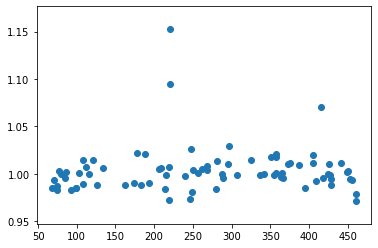

In [20]:
plt.scatter(x_pos[ids], Ps);

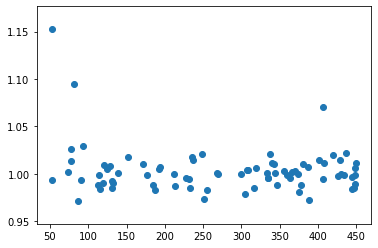

In [21]:
plt.scatter(y_pos[ids], Ps)

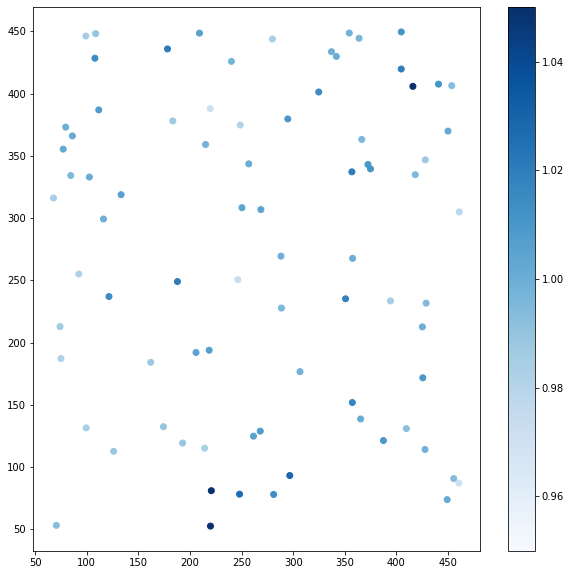

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(x_pos[ids], y_pos[ids], c=Ps, cmap='Blues', vmin=0.95, vmax=1.05)
plt.colorbar();

(0.93, 1.07)

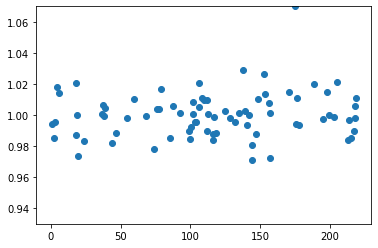

In [23]:
yc = (512 - 50) / 2
plt.scatter(np.abs(y_pos[ids] - yc), Ps)
plt.ylim(0.93, 1.07)

In [ ]:
P_true = np.nanmedian(Ps[(y_pos[ids] > 50) & (y_pos[ids] < 150)])
print(P_true)
P_true = np.nanmedian(Ps[(y_pos[ids] > 150) & (y_pos[ids] < 250)])
print(P_true)
P_true = np.nanmedian(Ps[(y_pos[ids] > 250) & (y_pos[ids] < 350)])
print(P_true)
P_true = np.nanmedian(Ps[(y_pos[ids] > 350) & (y_pos[ids] < 450)])

In [ ]:
##N.B. source_table = source_table[(source_table['ycentroid'] > 50) & (source_table['ycentroid'] < (ny - 60))]
# i.e. (ny - 50) -> (ny - 60)

In [ ]:
def P_true_calc(ys, ps, s):
    
    y_pos = ys[s]
    
    ps = np.array(photometric_)
    ys = np.array(y)
    
    if 50 < y_pos < 150:
        P_true = np.nanmedian(ps[(ys > 50) & (ys < 150)])
    elif 150 < y_pos < 250:
        P_true = np.nanmedian(ps[(ys > 150) & (ys < 250)])
    elif 250 < y_pos < 350:
        P_true = np.nanmedian(ps[(ys > 250) & (ys < 350)])            
    elif 350 < y_pos < 450:
        P_true = np.nanmedian(ps[(ys > 350) & (ys < 450)])#
        
    return P_true

P_true = P_true_calc(ys, ps, s)

In [ ]:
                    '''
                    ## psf fit
                    F_diff = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                    const = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                    print('Starting F_diff and const:', F_diff, const)

                    #print(model.shape, stamp_fit.shape, noise_stamp_fit.shape)
                                        

                    target_psf_object = torch.from_numpy(psf)
                    stamp_fit = torch.from_numpy(np.array(stamp_fit, dtype=np.float32))
                    noise_stamp_fit = torch.from_numpy(np.array(noise_stamp_fit, dtype=np.float32))

                    class log_likelihood(torch.nn.Module):

                        def forward(model, stamp, noise_stamp):
                            #print(stamp.size(), model.size(), noise_stamp.size())
                            #loglikelihood = -0.5*(((stamp - model)/noise_stamp)**2).sum()

                            ln_sigma = torch.sum(torch.log(noise_stamp))

                            # gaussian when (model - targ)/NM <= c
                            # absolute deviation when (model - targ)/NM > c
                            c = 1.345
                            cond1 = torch.abs((model - stamp)/noise_stamp) <= c
                            cond2 = torch.abs((model - stamp)/noise_stamp) > c
                            inliers = ((model - stamp)/noise_stamp)[cond1]
                            outliers = ((model - stamp)/noise_stamp)[cond2]

                            l2 = 0.5*torch.sum(torch.pow(inliers, 2))
                            l1 = (c * torch.sum(torch.abs(outliers)) - (0.5 * c**2))

                            nll = l2 + l1 + ln_sigma
                            #return -loglikelihood
                            return nll

                    optimizer = torch.optim.Adam([F_diff, const], lr=1000)

                    tol = 1e-10
                    losses = []
                    for step in range(0, 150000):
                        optimizer.zero_grad()
                        psf_model = F_diff*target_psf_object + const
                        loss = log_likelihood.forward(psf_model, stamp_fit, noise_stamp_fit)
                        losses.append(loss.item())
                        loss.backward()
                        optimizer.step()

                        if step>1 and abs((losses[-1] - losses[-2])/losses[-2]) < tol:
                            print('Converged')
                            break

                    
                    print('Final F and const:', F_diff, const)

                    ## convert tensors back to numpy arrays
                    F_diff = F_diff.detach().numpy()
                    const = const.detach().numpy()
                    target_psf_object = target_psf_object.detach().numpy()
                    stamp_fit = stamp_fit.detach().numpy()
                    noise_stamp_fit = noise_stamp_fit.detach().numpy()
                    
                    '''

In [18]:
data = np.loadtxt('pyDANDIA_OGLE_BLG101_NoPad_StackedRef.txt')
data.shape

(7746, 9)

In [19]:
source_table

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
29,219.8785511700297,52.509408621781795,0.5023109260734715,-0.0028868254016730433,0.05032760401503506,81,0.0,12303.08203125,2.908658790218432,-1.1592319447327548
30,70.5490749184299,53.111393276731484,0.4875640325413746,0.09676193329655995,0.006450483462253346,81,0.0,212407.515625,54.75562252578023,-4.346071802230066
41,449.2481627464416,73.77639519142606,0.46215422261442646,-0.047795121068534126,0.006295104923461038,81,0.0,14076.498046875,3.7124571059871663,-1.424153611206641
43,248.05001553666636,78.15558146239145,0.48813573141530464,0.08685678552616219,0.04715321584446844,81,0.0,40011.44140625,10.531827141149275,-2.556259306045889
44,281.0798617512121,77.9413906170773,0.4943859409920509,0.11322030294090041,0.03592985560163198,81,0.0,113230.625,29.68348706058696,-3.6812872956123988
45,220.70147320227036,80.94319732464395,0.46642265727740756,0.11446850234401407,0.015326437454863314,81,0.0,22525.12890625,6.110231847006462,-1.9651442236281682
46,460.5628151068725,87.03652564895934,0.5187301767188992,0.30237852281817845,-0.23363386627958038,81,0.0,10044.6640625,1.6751205370800388,-0.5601151578429809
48,455.5833411727148,90.6784835801602,0.4899315416147083,-0.012167013717761216,-0.029780444578047464,81,0.0,55297.16796875,14.362645684931122,-2.893086117267973
49,296.7220821280347,93.13528257293395,0.4832823438755105,0.08010742722697277,0.03380560197591897,81,0.0,84734.3125,22.32154202426702,-3.3718104834480855


In [20]:
ids = np.unique(data[:, -3]).astype(int)

# identified outliers
outliers = np.array([])

# individual light-curve offsets
shift_info = np.zeros((len(ids), 2))

# sigma cutoff
sigma_cut = 100

# variances
variances = []

for i in ids:
    
    # 'raw' normalised photometric residuals
    nr = data[:,3][data[:, -3] == i]
    
    print('Source: %d, Mean:%f, Median:%f, Variance:%f, MAD Var:%f, N:%d' % (i, np.mean(nr), np.median(nr), 
                                                                       np.nanvar(nr),
                                                                       mad_std(nr)**2, len(nr)))
    
    
    if np.nanvar(nr) > sigma_cut:
        outliers = np.append(outliers, i)
        
    shift_info[i][0], shift_info[i][1] = i, np.nanmedian(nr)
    
    
    variances.append(np.nanvar(nr))

Source: 0, Mean:0.326340, Median:0.614289, Variance:3.400302, MAD Var:3.466355, N:27
Source: 1, Mean:-3.341258, Median:-4.081265, Variance:11.510670, MAD Var:9.258680, N:30
Source: 2, Mean:-0.296473, Median:-0.118948, Variance:3.900163, MAD Var:3.252907, N:82
Source: 3, Mean:-0.895595, Median:-1.310673, Variance:10.922249, MAD Var:11.938701, N:97
Source: 4, Mean:-1.853058, Median:-1.572605, Variance:20.593889, MAD Var:16.465597, N:97
Source: 5, Mean:-1.001326, Median:-0.845532, Variance:4.103590, MAD Var:4.847004, N:97
Source: 6, Mean:0.068142, Median:0.080055, Variance:1.380922, MAD Var:1.880214, N:50
Source: 7, Mean:1.225214, Median:0.945873, Variance:2.458414, MAD Var:2.637864, N:66
Source: 8, Mean:0.309505, Median:0.173496, Variance:5.502717, MAD Var:6.514526, N:97
Source: 9, Mean:0.205193, Median:0.300444, Variance:2.256472, MAD Var:2.508727, N:83
Source: 10, Mean:0.496825, Median:0.463928, Variance:3.806173, MAD Var:3.452365, N:97
Source: 11, Mean:0.792663, Median:0.608397, Varia

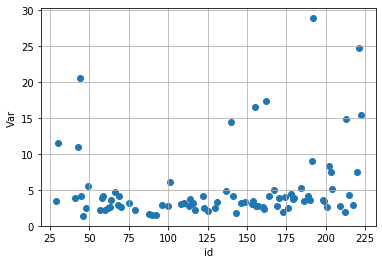

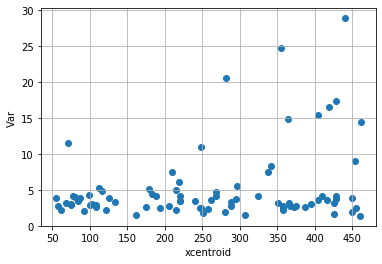

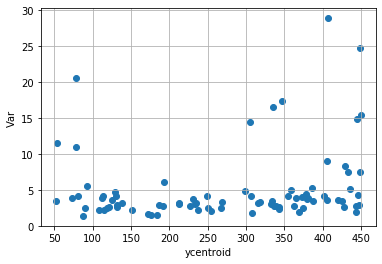

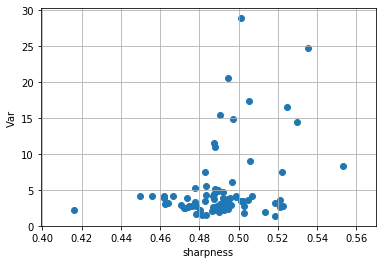

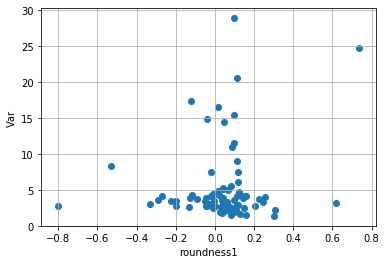

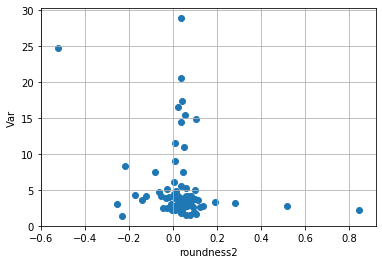

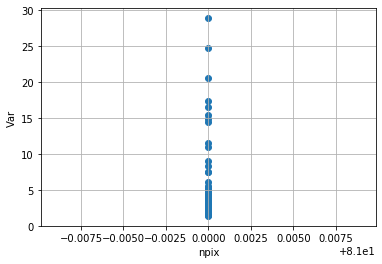

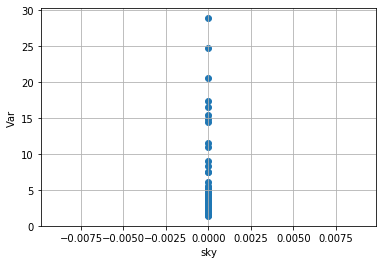

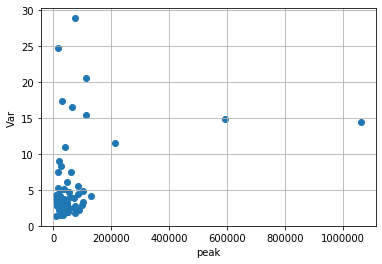

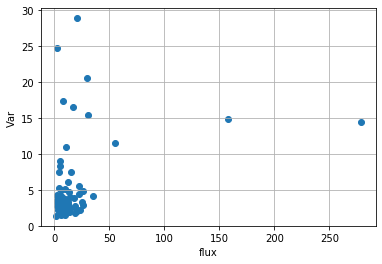

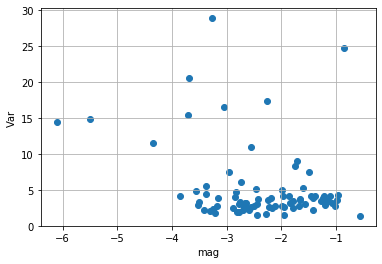

In [30]:
for name in source_table.colnames:
    plt.scatter(source_table[name], variances)
    plt.xlabel(name)
    plt.ylabel('Var')
    plt.grid()
    plt.show();